In [2]:
# GET PARAMETERS
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config
from plotting.plotting import error_per_station_calendar_pattern

'pynvml' is not available on this environment.
Training and Hyper-parameter tuning with Ray is not possible


## Gestion des outliers: Estimation du Flux Max d'une station
- De Nombreux outliers présents à Perrache, d'autres assez élevée sur les autres stations. On va essayer de gérer ces outliers. 
    - On prend un Flux maximal enregistré : le Flux in max en 15min enregistré pendant la fête des lumière
        - Le Flux max est enregistré à Bellecour, autour de 2500 personnes / 15 minutes
        - Le second Flux max est enregistré à Charpennes, autour de 1600 personnes / 15 minutes
        - Le 3eme Flux max est enregsitré à Gorge de Loup, autour de 1600 personnes / 15 minutes
        - Aucunes des autres stations n'a dépassée 1400, même pendant la fête des lumières. 

- On choisit donc d'inputer la données, par interpolation linéaire, pour tout les flux dépassant:
    -  2500 pour bellecour
    - 1600 pour charpnnes et gorge de Loup
    - 1400 pour les autres stations.

# Comparaison des flux avec ce qu'on peut trouver sur les validations individuelles:

In [ ]:
import pandas as pd
import glob
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from constants.paths import FOLDER_PATH

list_files = glob.glob(f"{parent_dir}/{FOLDER_PATH}/validations_individuelles/*.txt")

# Load df :


path_txt = list_files[1]
df = pd.read_csv(path_txt, sep = "\t")
df['is_subway'] = df.EMP_CEB.transform(lambda x : x[:3])
df_subway = df[df['is_subway'] == 'VMM']   # Extract Funicular and Subway, starting both by "VMM"

df_subway['subway_mode'] = df_subway.EMP_CEB.transform(lambda x : x[:4])
df_subway = df_subway[df_subway['subway_mode'] != 'VMMF'] # Extract VVMx and remove VMMF (i.e. Subway Lane, excluding Funicular)
df_subway.VAL_DATE = pd.to_datetime(df_subway.VAL_DATE)

if False:
    # Load ref subway
    ref_subway = pd.read_csv(f"{folder_path}/ref_subway.csv").rename(columns = {'MEAN_X' : 'lon','MEAN_Y':'lat'})
    ref_subway = ref_subway[['lon','lat','COD_TRG','LIB_STA_SIFO']]

#Get Subway  
df_subway['subway_mode'] = df_subway.EMP_CEB.transform(lambda x : x[:4])
df_subway = df_subway[df_subway['subway_mode'] != 'VMMF'] # Extract VVMx (i.e. Subway Lane)
df_subway['COD_TRG'] = df_subway.EMP_CEB.transform(lambda x : x[5:8])
df_subway['lane'] = df_subway.EMP_CEB.transform(lambda x : x[3])

<Axes: xlabel='VAL_DATE'>

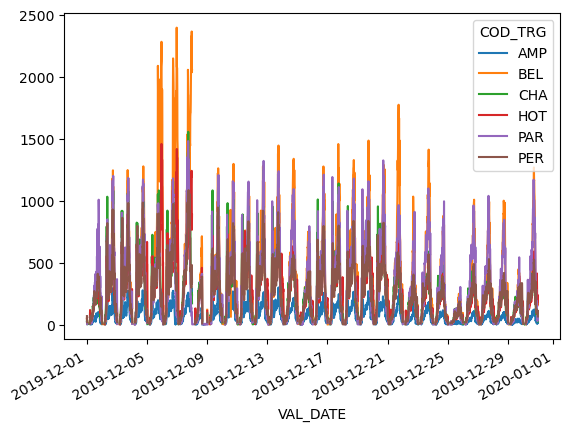

In [41]:
df_subway_agg = df_subway.groupby([pd.Grouper(freq='15min',key='VAL_DATE'),'COD_TRG']).count().iloc[:,0]
df_subway_agg.name = 'Flow'
df_subway_agg = df_subway_agg.reset_index()

#df_subway_agg[~df_subway_agg['COD_TRG'].isin(['CHA','BEL','GOR'])].pivot_table(index = 'VAL_DATE',columns = 'COD_TRG',values='Flow').plot()
df_subway_agg[df_subway_agg['COD_TRG'].isin(['HOT','BEL','CHA','AMP','PER','PAR'])].pivot_table(index = 'VAL_DATE',columns = 'COD_TRG',values='Flow').plot()
#df_subway_agg.pivot_table(index = 'VAL_DATE',columns = 'COD_TRG',values='Flow').plot()

## Génération de la configuration, choix des modification, entrainement et visalisation.
Args: 
--
- station : définie les station qui vont être regardée (visualisation profil time série réelle et prédiction)
- set_spatial_units: défini les stations qui vont être prise en compte lors de l'entrainement. La taille de 'set_spatial_unit' est donc la taille du graphe. Si non précisé, on fait la prédiction sur les 40 STATION du réseau.

In [3]:
# Init:
dataset_names = ["subway_in"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'
station = ['PER','FOC','SAN','FLA']   # 'BON'  #'GER'
# ...

#Modif 
modification = {'epochs' : 100, #100
                'lr':1e-4,
                'set_spatial_units':  station,       
                           }
# ...

# Training and visu: 
training_mode_to_visualise = ['test','valid','train']
(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,
                                                   station=station,modification=modification,
                                                   training_mode_to_visualise=training_mode_to_visualise)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Considered Spatial-Unit:  ['PER', 'FOC', 'SAN', 'FLA']

Init Dataset:  torch.Size([7392, 4])
Number of Nan Value:  tensor(0)
Total Number of Elements:  29568 

U/Utarget size: torch.Size([6238, 4, 7])/torch.Size([6238, 4, 1]) Train/Valid/Test 3742 1248 1247
----------------------------------------
Fold n°0
Considered Spatial-Unit:  ['PER', 'FOC', 'SAN', 'FLA']

Init Dataset:  torch.Size([2174, 4])
Number of Nan Value:  tensor(0)
Total Number of Elements:  8696 

U/Utarget size: torch.Size([2078, 4, 7])/torch.Size([2078, 4, 1]) Train/Valid 1558 519
Model size: 0.000GB
number of total parameters: 62497
number of trainable parameters: 62497

start training
epoch: 0 
 min\epoch : 0.02
Estimated time for training: 2.3min 

Training Throughput:1641.93 sequences per seconds
>>> Training complete in: 0:02:02.247302
>>> Training performance time: min 0.014220952987670898 avg 0.01906418800354004 seconds (+/- 0.001986277604034921)
>>> Loading perf

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

## Pattern d'erreur selon les stations : 

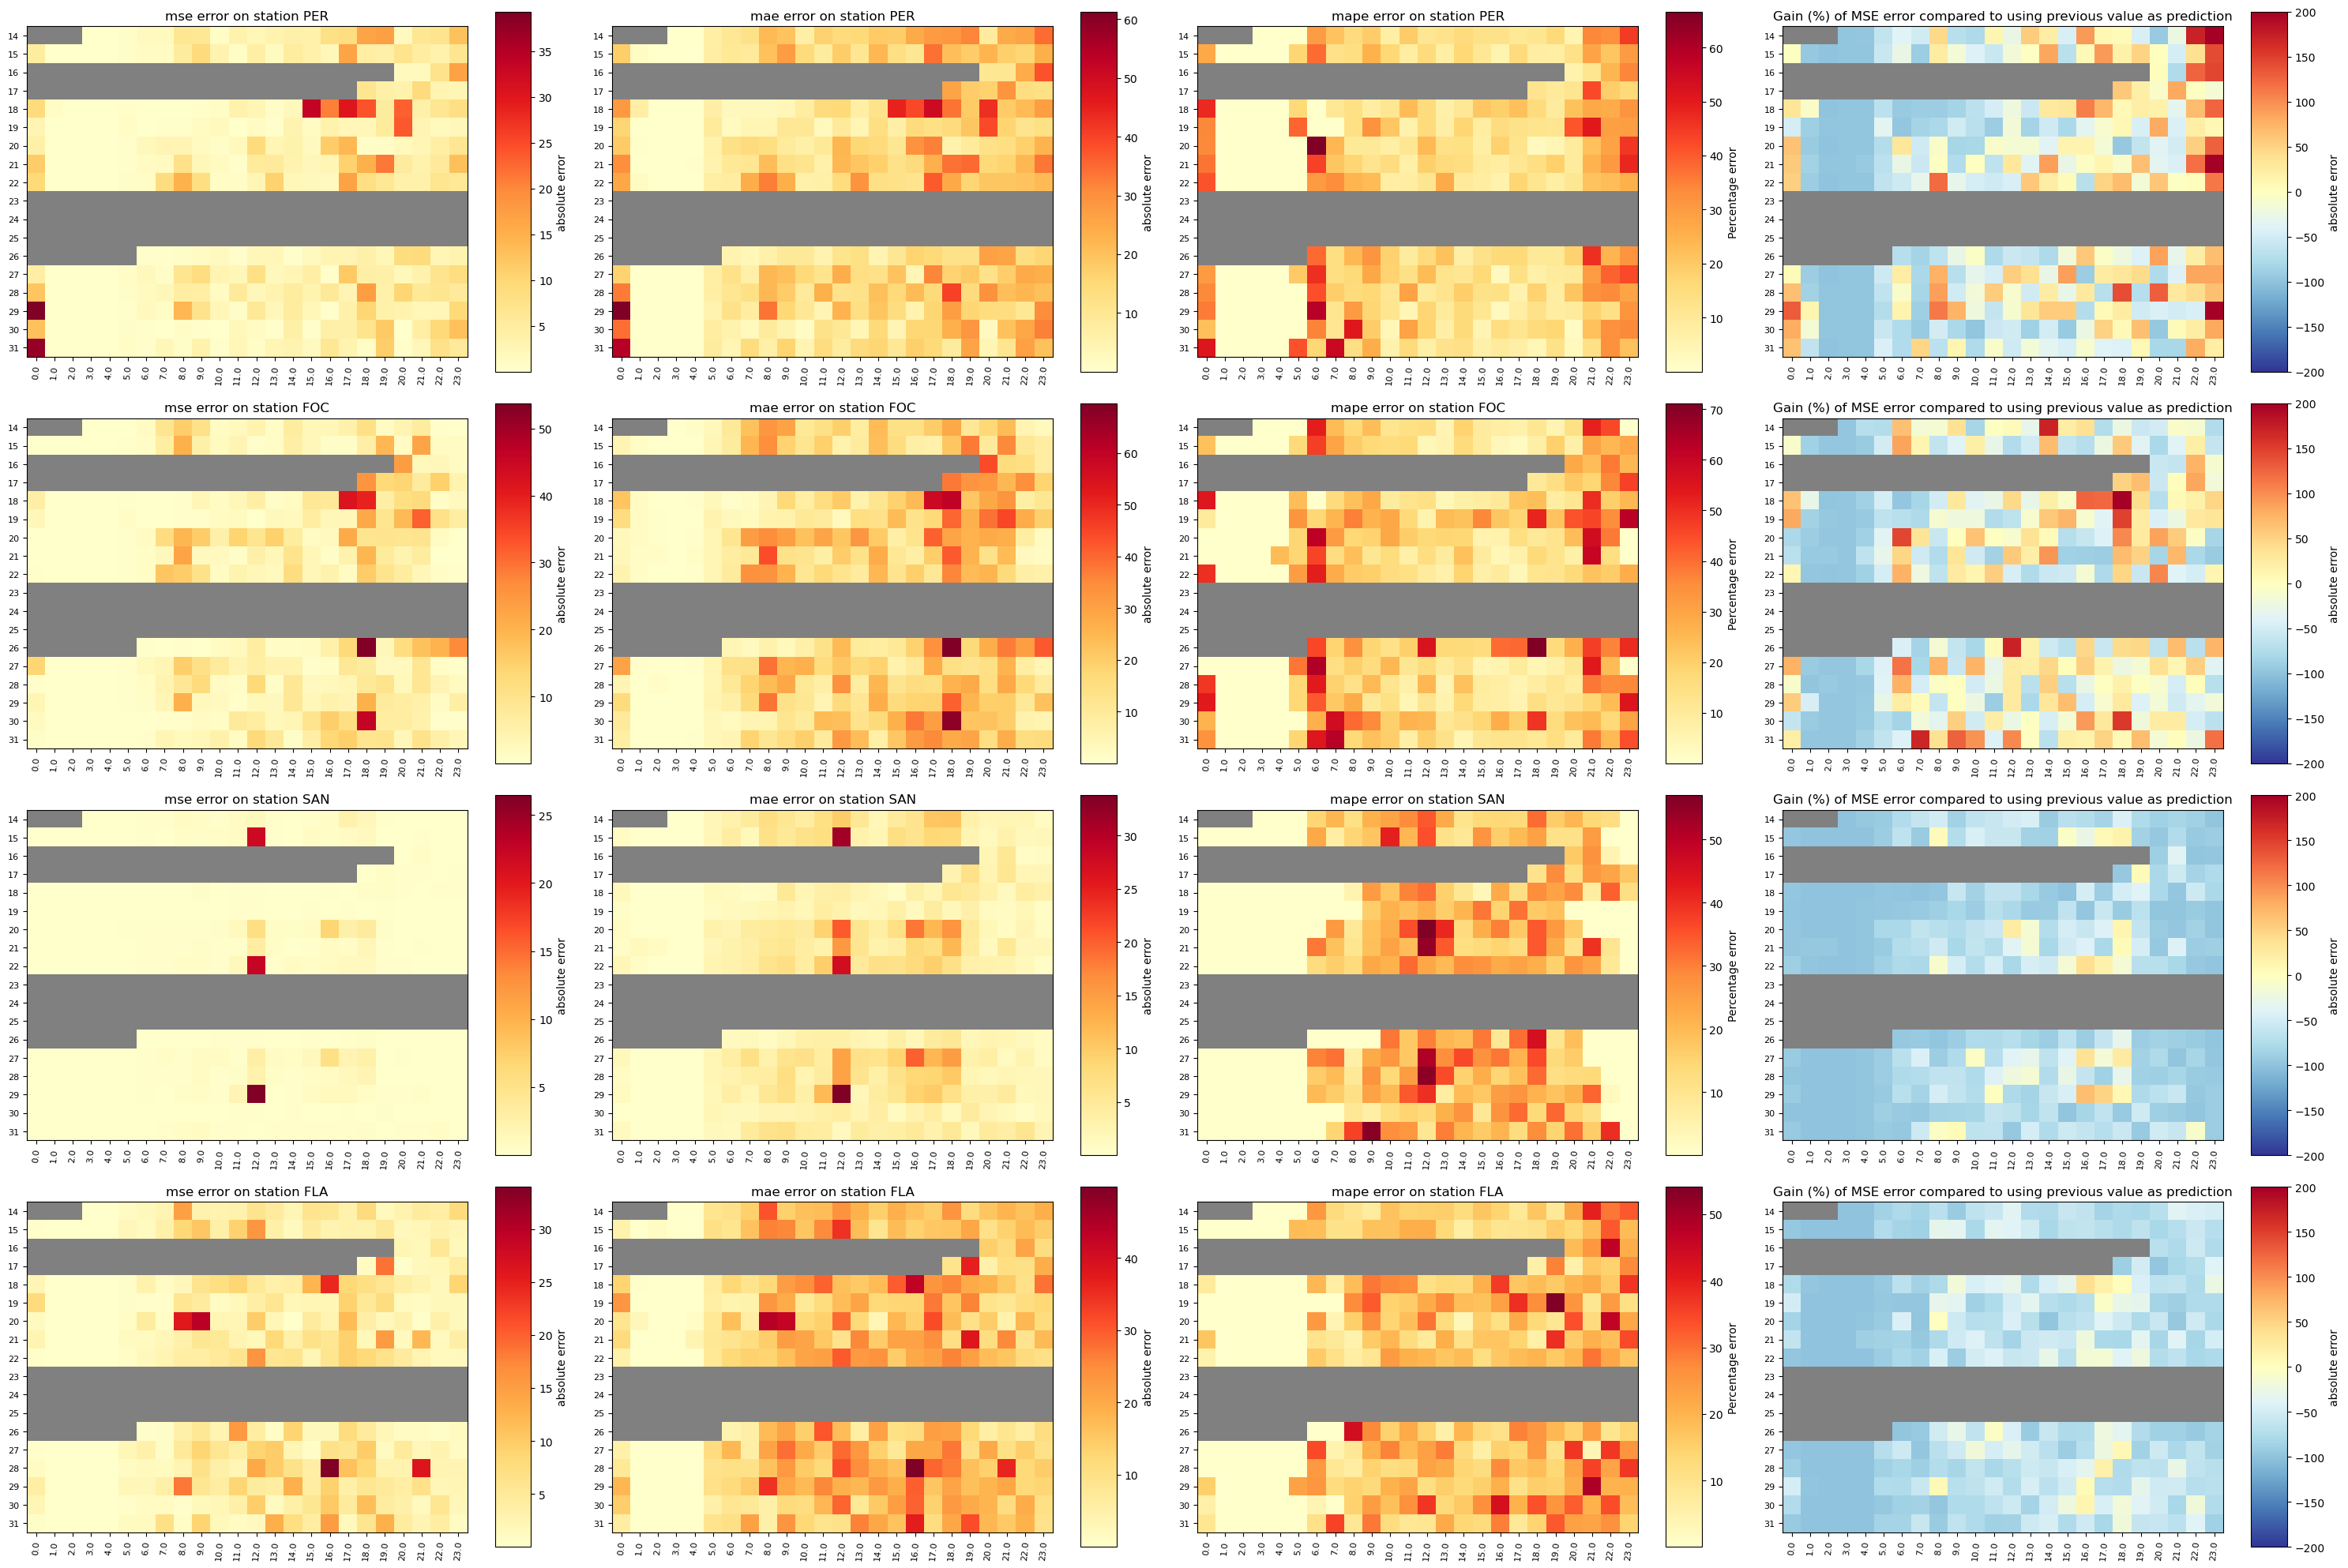

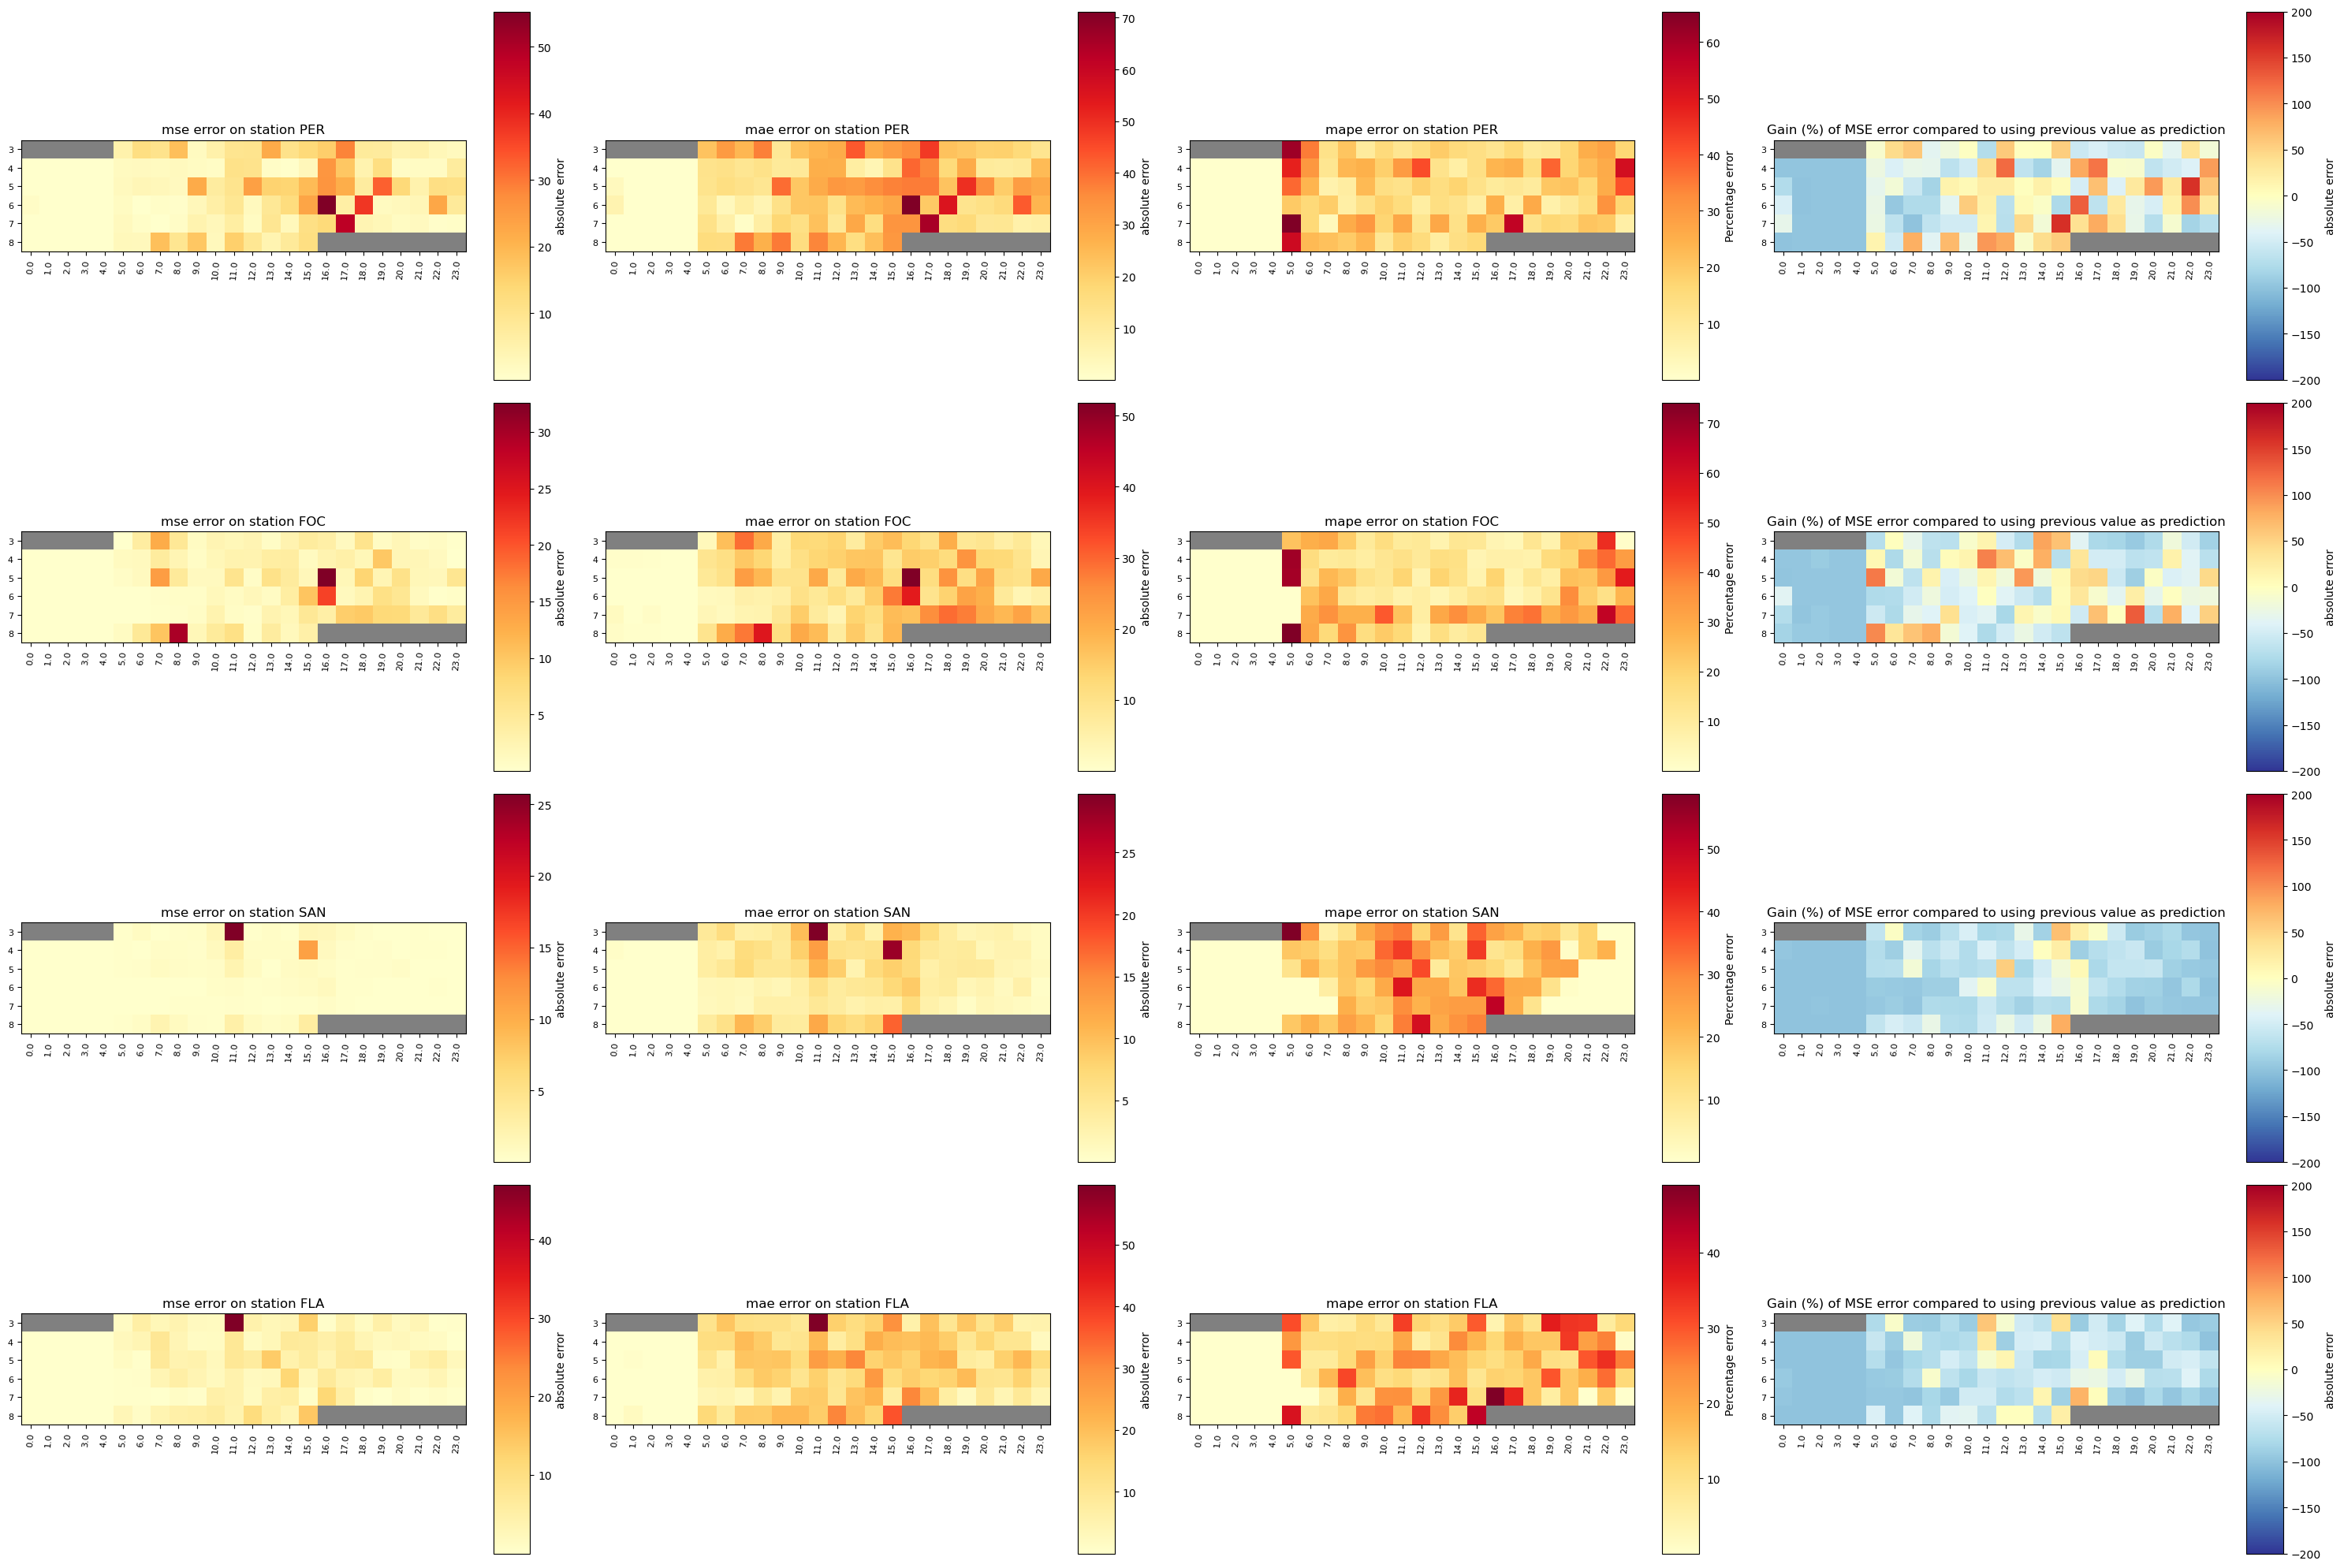

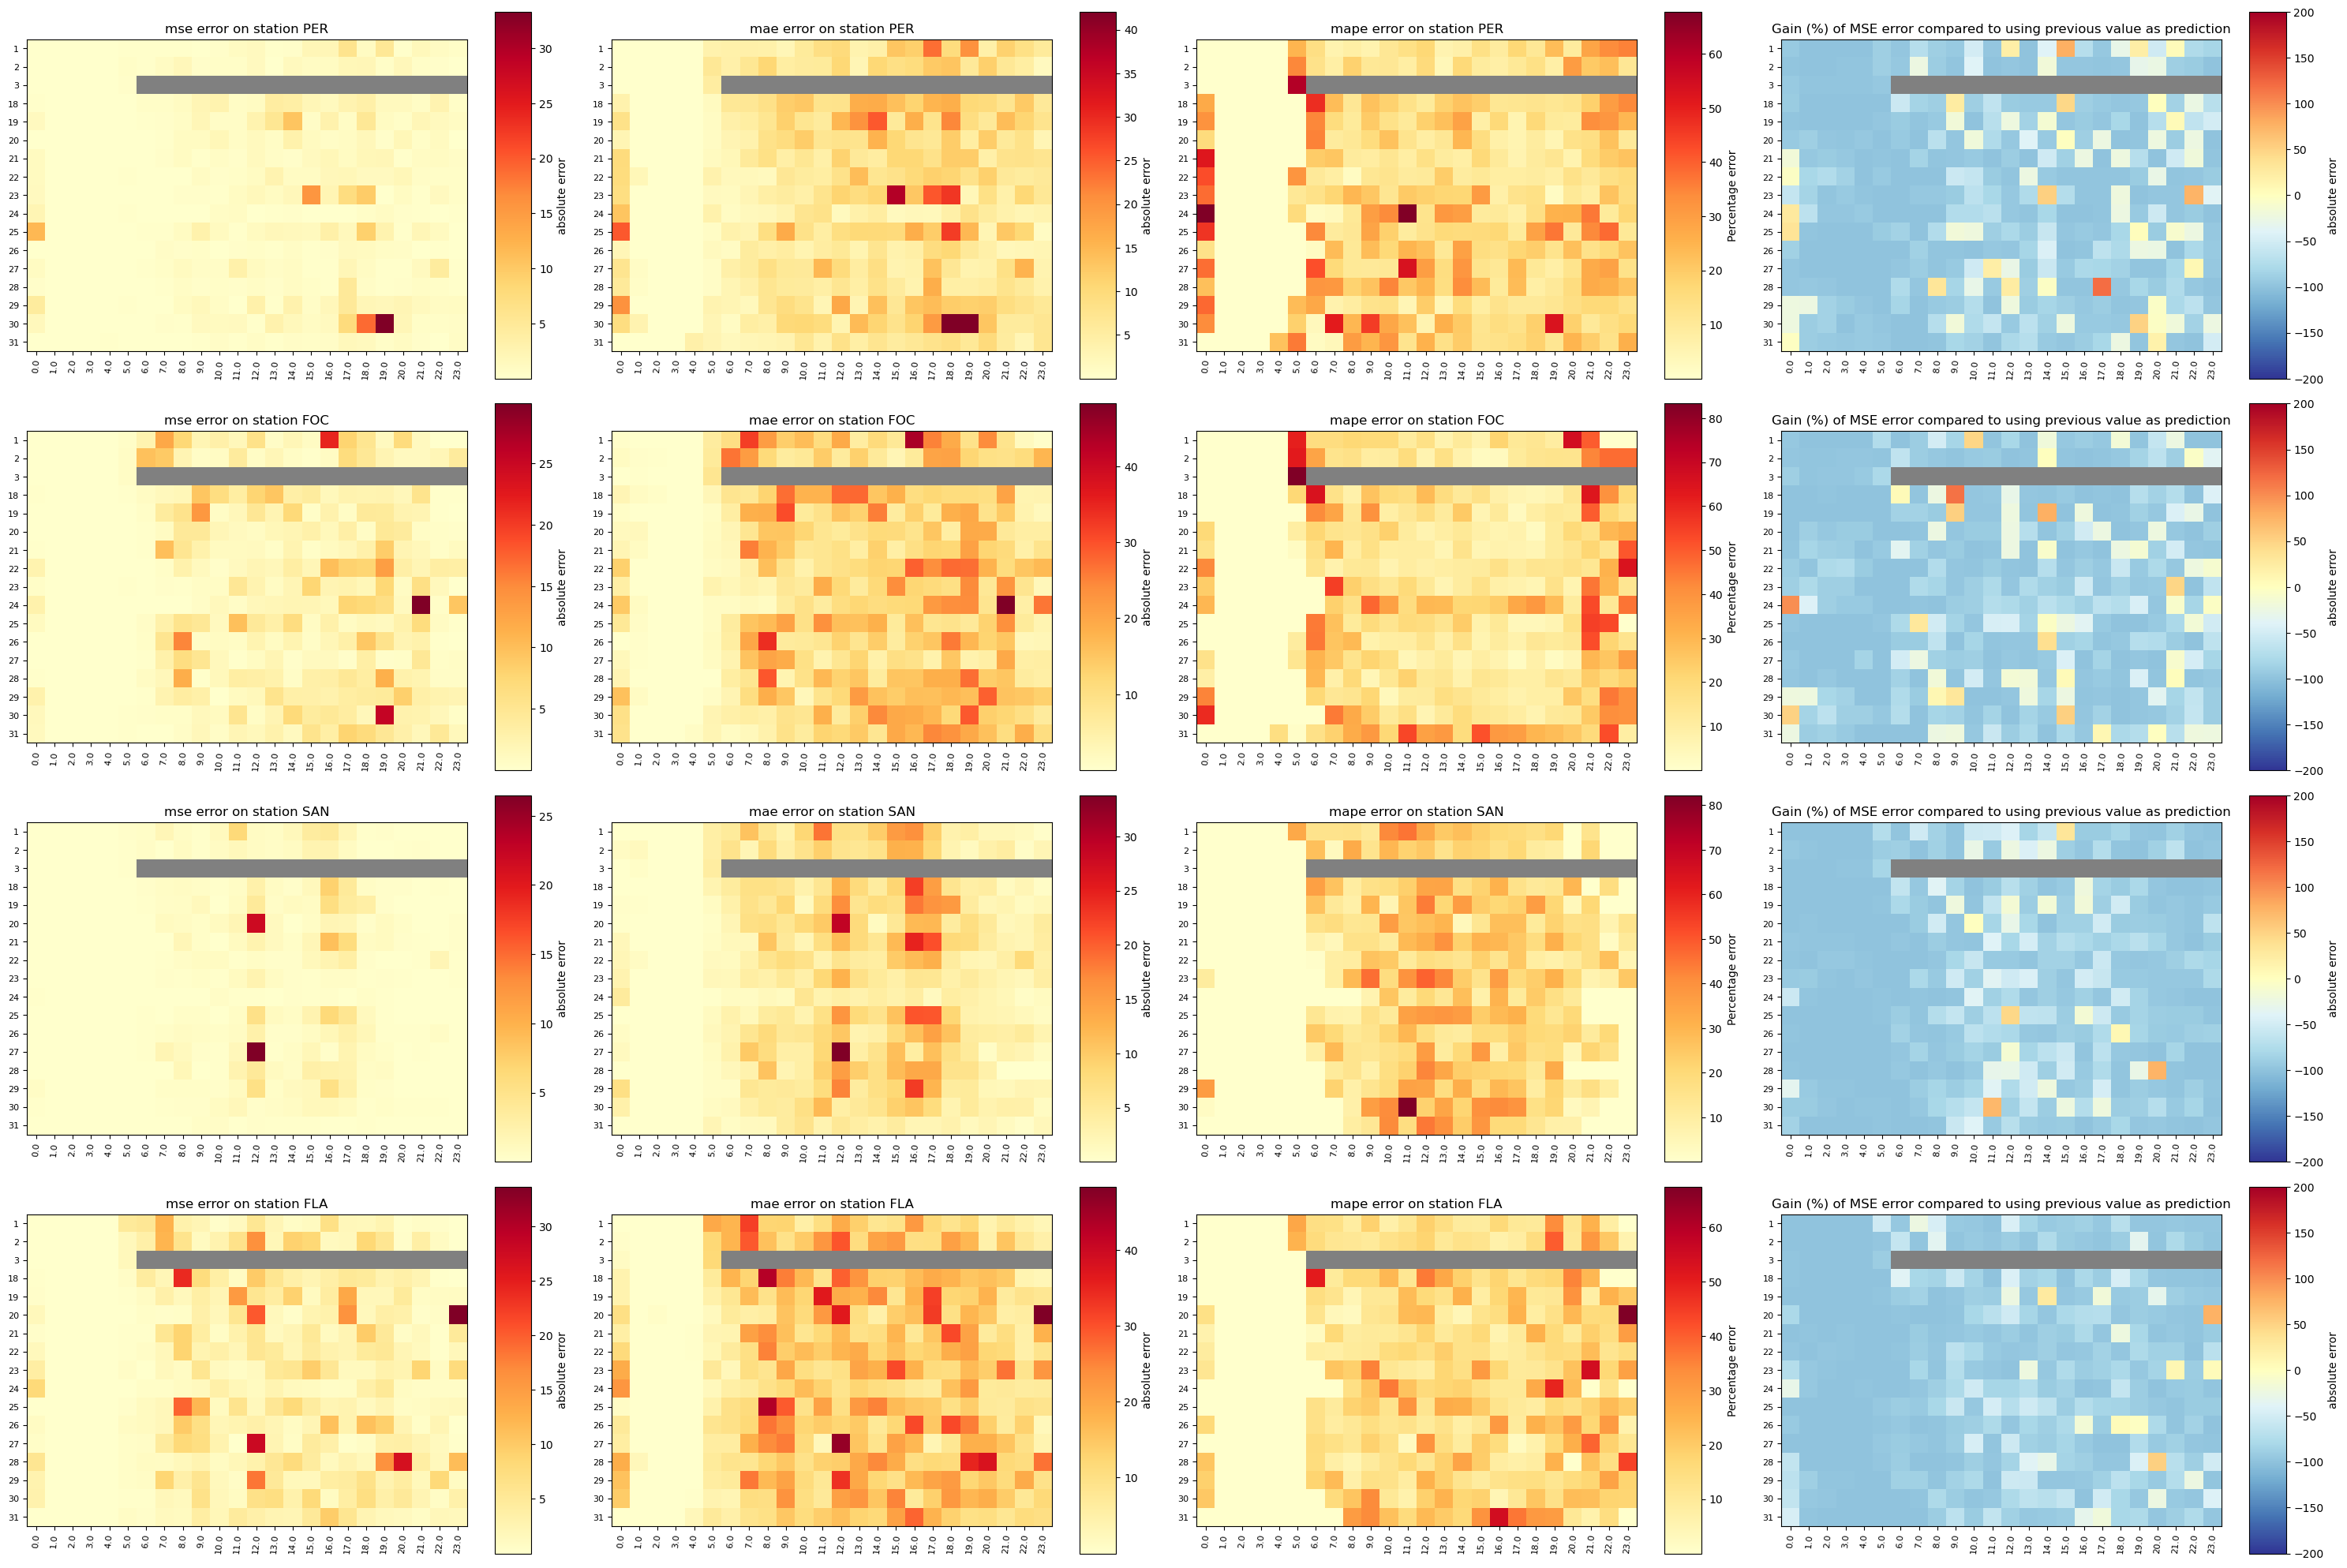

In [4]:
# Init
for training_mode in ['test','valid','train']:
    min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
    limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
    fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                freq='1h',
                                                min_flow=min_flow,
                                                figsize = (30,5*len(ds.spatial_unit)),
                                                limit_percentage_error = limit_percentage_error)

In [5]:
from examples.train_and_visu_non_recurrent import evaluate_config
from plotting.plotting import error_per_station_calendar_pattern

dataset_names = ["subway_in","calendar"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = ['PER','FOC','SAN','FLA']   # 'BON'  #'GER'


modification = {'epochs' : 250, #100
                'lr':1e-4,
                #'set_spatial_units': ['CHA','GER','BON','SOI'],#['CHA','GER','BON','SOI'],
                'TE_concatenation_late':False,
                'TE_concatenation_early':True,   
                'TE_embedding_dim' : 3,
                'TE_multi_embedding' : True ,         
                           }
training_mode_to_visualise = ['test']
(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,
                                                   station = station,modification=modification,training_mode_to_visualise=training_mode_to_visualise)

# Init
training_mode = 'test'
min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                              freq='1h',
                                              min_flow=min_flow,
                                              figsize = (30,5*len(ds.spatial_unit)),
                                              limit_percentage_error = limit_percentage_error)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

U/Utarget size: torch.Size([6238, 40, 7])/torch.Size([6238, 40, 1]) Train/Valid/Test 3742 1248 1247
----------------------------------------
Fold n°0

Init Dataset:  torch.Size([2174, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  86960 

U/Utarget size: torch.Size([2078, 40, 7])/torch.Size([2078, 40, 1]) Train/Valid 1558 519
number of Parameters in Embedding Module: 2325
Model size: 0.000GB
number of total parameters: 86326
number of trainable parameters: 86326

start training
epoch: 0 
 min\epoch : 0.12
Estimated time for training: 31.0min 

Training Throughput:227.06 sequences per seconds
>>> Training complete in: 0:33:46.519140
>>> Training performance time: min 0.0764310359954834 avg 0.13030719757080078 seconds (+/- 0.026428525809595288)
>>> Loading performance time: min 0.0004439353942871094 avg 0.08289223353

Loading BokehJS ...

In [6]:
from examples.train_and_visu_non_recurrent import evaluate_config
from plotting.plotting import error_per_station_calendar_pattern

dataset_names = ["subway_in"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = ['PER','FOC','SAN','FLA']   # 'BON'  #'GER'

modification = {'epochs' : 250, #100
                'lr':1e-4,
                }

training_mode_to_visualise = ['test']
(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,
                                                  station = station,
                                                  modification=modification,
                                                  training_mode_to_visualise=training_mode_to_visualise)

# Init
training_mode = 'test'
min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                              freq='1h',
                                              min_flow=min_flow,
                                              figsize = (30,5*len(ds.spatial_unit)),
                                              limit_percentage_error = limit_percentage_error)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

U/Utarget size: torch.Size([6238, 40, 7])/torch.Size([6238, 40, 1]) Train/Valid/Test 3742 1248 1247
----------------------------------------
Fold n°0

Init Dataset:  torch.Size([2174, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  86960 

U/Utarget size: torch.Size([2078, 40, 7])/torch.Size([2078, 40, 1]) Train/Valid 1558 519
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713

start training
epoch: 0 
 min\epoch : 0.11
Estimated time for training: 29.6min 


In [ ]:
import torch
import pandas as pd
index_perrache = list(ds.spatial_unit).index('PER')
inputs = [[x,y,x_c] for  x,y,x_c in ds.dataloader['test']]
X = torch.cat([x for x,_,_ in inputs],0)
Y = torch.cat([y for _,y,_ in inputs],0)
#X_c = torch.cat([x_c for x,_,_ in inputs],-1)
l = 96
pd.DataFrame({'PER_TRUE': Y[:,index_perrache,0].detach().clone().reshape(-1),
              #'t-1': X[:,index_perrache,-1].detach().clone().reshape(-1),
              #'t-2': X[:,index_perrache,-2].detach().clone().reshape(-1),
              #'t-3': X[:,index_perrache,-3].detach().clone().reshape(-1),
              #'t-4': X[:,index_perrache,-4].detach().clone().reshape(-1),
              #'t-5': X[:,index_perrache,-5].detach().clone().reshape(-1),
              #'t-6': X[:,index_perrache,-6].detach().clone().reshape(-1),
              't-d': X[:,index_perrache,-7].detach().clone().reshape(-1),
              }).iloc[l:l+7*l].plot()


In [ ]:
from examples.train_and_visu_non_recurrent import evaluate_config
dataset_names = ["subway_in","calendar"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = 'GER'  # 'BON'  #'GER'
apps = ['Google_Maps']# ['Instagram','Twitter','Google_Maps'] # 'Instagram'  # 'Twitter' # 'Google_Maps' # 'Facebook'


transfer_modes = ['DL'] # ['DL'] # ['UL'] # ['DL','UL']
type_POIs = ['stadium'] #['stadium','station'] #['stadium','nightclub'] #['stadium']
spatial_units = ['Matmut Stadium Gerland','GER']  #spatial_units = ['Lou_rugby']  # ['Astroballe'] #['Lou_rugby','Ninkasi_Kao'] #['Lou_rugby'] #['Ninkasi_Kao'] 
expanded = '_expanded' # '' # '_expanded' # ''
POI_or_stations = ['POI']# ['POI','station'] # 'station'
modification = {'epochs' : 400, #100
                'lr':1e-4,
                'set_spatial_units': ['CHA','GER','BON','SOI'],#['CHA','GER','BON','SOI'],
                'TE_concatenation_late':False,
                'TE_concatenation_early':True,   
                'TE_embedding_dim' : 2,
                'TE_multi_embedding' : True ,         
                           }
training_mode_to_visualise = ['test']
(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,transfer_modes= transfer_modes,
                                                   type_POIs = type_POIs,spatial_units = spatial_units,apps = apps,POI_or_stations = POI_or_stations,
                                                   expanded=expanded,modification=modification,training_mode_to_visualise=training_mode_to_visualise)

## Evaluate on non recurrent event: 
### Visualisation: 
#### Cas `subway_in` stade du Lou Gerland avec un match de Rugby : 

## HP tuning: 

In [ ]:
from examples.Total_evaluation_of_model import HP_and_valid_one_config,hyperparameter_tuning
from examples.benchmark import local_get_args
import pickle

model_name = 'STGCN' #'CNN'
dataset_for_coverage = ['subway_in','netmob_POIs'] 
dataset_names = ['calendar']
vision_model_name = None

args,_,_ = local_get_args(model_name,
                        args_init = None,
                        dataset_names=dataset_names,
                        dataset_for_coverage=dataset_for_coverage,
                        modification = {'ray':True,
                                        'grace_period':2,
                                        'HP_max_epochs':10,
                                        'evaluate_complete_ds' : True,
                                        'set_spatial_units' : ['BON','SOI','GER','CHA'],
                                        'vision_model_name': None
                                        })

# Init 
epochs_validation = 30
num_samples = 10

# HP and evaluate K-fold best config
#HP_and_valid_one_config(args,epochs_validation,num_samples)
analysis,trial_id = hyperparameter_tuning(args,num_samples)
print('trial_id: ',trial_id)



## Load HP tuning, have a look on the best configurations:

In [ ]:
pd.read_csv(path_csv)['']

In [ ]:
import pickle 
import pandas as pd 

# 2000 Trial et 100 Epochs: 
trial_ids = ['subway_in_calendar_STGCN_MSELoss_2024_12_19_07_15_69445','subway_in_STGCN_MSELoss_2024_12_19_21_10_79120']

# 'subway_in_STGCN_MSELoss_2024_12_11_00_16_42861'   -> 'Seulement' 400 trials, et 50 epochs 
for trial_id in trial_ids:
    columns_to_drop = ['time_this_iter_s', 'done', 'date', 
                    'timestamp', 'time_total_s', 'pid', 'hostname', 'node_ip',
                    'time_since_restore', 'iterations_since_restore', 'experiment_tag']
    path_csv = f'save/HyperparameterTuning/{trial_id}.csv'
    path_pickle = 'save/HyperparameterTuning/model_args.pkl'

    df_hp_tuning = pd.read_csv(path_csv)
    model_args = pickle.load(open(path_pickle,'rb'))


    metric = 'Loss_model'

    dict_rename = {key: key.split('/')[-1] for key in df_hp_tuning.columns}
    df_hp_tuning = df_hp_tuning.rename(columns = dict_rename)
    df_hp_tuning = df_hp_tuning.drop(columns = columns_to_drop)


    k=10
    print(df_hp_tuning.shape)
    display(df_hp_tuning.sort_values(metric).iloc[:k])

In [ ]:
save_folder = 'save/K_fold_validation/training_with_HP_tuning'

for trial_id in trial_ids:
    print(f'\n{trial_id}')
    metric_csv = f'{save_folder}/METRICS_{trial_id}.csv'
    df_metrics_k_fold_valid = pd.read_csv(metric_csv,index_col =0)

    losses_csv = f'{save_folder}/Losses_{trial_id}.csv'
    df_losses_k_fold_valid = pd.read_csv(losses_csv,index_col =0)

    display(df_metrics_k_fold_valid)
    usefull_columns = [c for c in df_losses_k_fold_valid.columns if 'valid' in c]
    df_losses_k_fold_valid[usefull_columns].iloc[10:].plot()

In [ ]:
import numpy as np 
from examples.train_model_on_k_fold_validation import train_valid_K_models,get_model_metrics
from examples.benchmark import local_get_args


# TE modification: 
TE_modification = {'TE_concatenation_early':True,
                  'TE_multi_embedding':True,
                  'TE_concatenation_late': False,
                  'TE_out_h_dim':4,
                  'TE_embedding_dim':4
               }


for dataset_names,te_modif in zip([['subway_in','calendar'],['subway_in']],[TE_modification,{}]):
   ### === Modification :
   modification = {'evaluate_complete_ds':True,
                  'temporal_h_dim':32,
                  'spatial_h_dim':8,
                  'output_h_dim':64,
                  'dropout':5e-2,
                  'weight_decay':5e-3,
                  'lr':5e-4,
                  'epochs':2
                  }
   modification.update(te_modif)
   ### _____________________

   # Load Config
   args,_,_ = local_get_args(model_name= 'STGCN',
                           args_init=None,
                           dataset_names= dataset_names,
                           dataset_for_coverage= ['subway_in','netmob_POIs'] ,
                           modification=modification
                           )

   # Train, Valid: K-fold and complete ds 
   trainer,args,valid_losses,training_mode_list,metric_list,df_loss = train_valid_K_models(args,
                                                                                          folds=np.arange(args.K_fold),
                                                                                          hp_tuning_on_first_fold=True,
                                                                                          trial_id= None,
                                                                                          save_folder=None)
   # Get metrics: 
   df_results,df_metrics =  get_model_metrics(trainer,args,valid_losses,training_mode_list,metric_list)

   display(df_results)
   display(df_metrics)

   df_losses = pd.DataFrame({'Valid_loss':trainer.valid_loss,
               'Train_loss':trainer.train_loss
               })[10:]

   df_losses.plot()

In [ ]:
from examples.train_model_on_k_fold_validation import load_configuration
from examples.train_and_visu_non_recurrent import evaluate_config

trial_id = 'calendar_STGCN_MSELoss_2024_12_17_21_18_13719'
best_args,folds = load_configuration(trial_id,load_config=True,epochs=None)

dict_keys_embedding = {'TE_concatenation_order/concatenation_late':'TE_concatenation_late',
            'TE_concatenation_order/concatenation_early':'TE_concatenation_early',
             'TE_fc1/fc1':'TE_fc1', 
             'TE_fc1/fc2':'TE_fc2', 
             'TE_fc1/activation_fc1':'TE_activation_fc1',
             }

for key in dict_keys_embedding.keys():
    value = vars(best_args)[key]
    new_key = dict_keys_embedding[key]
    setattr(best_args,new_key,value)


modification = vars(best_args)


dataset_names = ["calendar"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = 'GER'  # 'BON'  #'GER'
apps = ['Google_Maps']# ['Instagram','Twitter','Google_Maps'] # 'Instagram'  # 'Twitter' # 'Google_Maps' # 'Facebook'


transfer_modes = ['DL'] # ['DL'] # ['UL'] # ['DL','UL']
type_POIs = ['stadium'] #['stadium','station'] #['stadium','nightclub'] #['stadium']
spatial_units = ['Matmut Stadium Gerland','GER']  #spatial_units = ['Lou_rugby']  # ['Astroballe'] #['Lou_rugby','Ninkasi_Kao'] #['Lou_rugby'] #['Ninkasi_Kao'] 
expanded = '_expanded' # '' # '_expanded' # ''
POI_or_stations = ['POI']# ['POI','station'] # 'station'

(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,transfer_modes= transfer_modes,
                                                   type_POIs = type_POIs,spatial_units = spatial_units,apps = apps,POI_or_stations = POI_or_stations,
                                                   expanded=expanded,modification=modification,station=station)

In [ ]:
dataset_names = ["calendar"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'
vision_model_name =  None

station = 'GER'  # 'BON'  #'GER'
apps = ['Google_Maps']# ['Instagram','Twitter','Google_Maps'] # 'Instagram'  # 'Twitter' # 'Google_Maps' # 'Facebook'


transfer_modes = ['DL'] # ['DL'] # ['UL'] # ['DL','UL']
type_POIs = ['stadium'] #['stadium','station'] #['stadium','nightclub'] #['stadium']
spatial_units = ['Matmut Stadium Gerland','GER']  #spatial_units = ['Lou_rugby']  # ['Astroballe'] #['Lou_rugby','Ninkasi_Kao'] #['Lou_rugby'] #['Ninkasi_Kao'] 
expanded = '_expanded' # '' # '_expanded' # ''
POI_or_stations = ['POI']# ['POI','station'] # 'station'
modification = {'epochs' : 20, #100
                'lr':1e-4,
                'temporal_h_dim' : 32,
                'spatial_h_dim' : 16,
                'output_h_dim' : 32,
                'TE_embedding_dim': 16,
                'set_spatial_units': ['CHA','GER','BON','SOI'],
                'TE_out_h_dim': 16,
                'TE_concatenation_late':False,
                'TE_concatenation_early':True,
                           }
(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,vision_model_name,transfer_modes= transfer_modes,
                                                   type_POIs = type_POIs,spatial_units = spatial_units,apps = apps,POI_or_stations = POI_or_stations,
                                                   expanded=expanded,modification=modification)


# lr 5e-3
# 32 / 32 / 32 - 3.5e-2   , 380 000
# 32 / 16 / 32 - 3.5e-2   , 380 000

#### Cas `subway_out` stade du Lou Gerland avec un match de Rugby : 

#### Cas `subway_in` Laurent Bonnevay Astroballe avec un match de Basket : 

#### Cas `subway_out` Laurent Bonnevay Astroballe avec un match de Basket : 

## Maintenant on va intégrer les données NetMob et voir si elles permettent de réduire l'erreur de prédiction :

In [1]:
import os 
import pickle 
import pandas as pd 

trial_id = 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2024_12_07_02_55_5679'
#'subway_in_calendar_STGCN_MSELoss_2024_12_12_15_51_46099'
#'subway_in_calendar_STGCN_MSELoss_2024_12_12_14_16_71587'

path_csv = f'save/HyperparameterTuning/{trial_id}.csv'
path_pickle = 'save/HyperparameterTuning/model_args.pkl'
df_hp_tuning = pd.read_csv(path_csv)
model_args = pickle.load(open(path_pickle,'rb'))

metric = '_metric/Loss_model'

best_model = df_hp_tuning.sort_values(metric).iloc[0]
HP_args = [indx.replace('config/', '') for indx in best_model.index if 'config/' in indx]
args = model_args['model'][trial_id]['args']

In [ ]:
print(df_hp_tuning.columns)

df_hp_tuning.sort_values(metric)[['_metric/Loss_model', 'config/lr', 'config/weight_decay',
       'config/dropout', 'config/vision_vision_grn_out_dim']].iloc[:30]

In [ ]:
dataset_names = ["subway_in","netmob_image_per_station"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'
vision_model_name =  'ImageAvgPooling'

(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,vision_model_name)

#### Prediction avec uniquement NetMob, sans subway-in: 

#### Prediction avec uniquement Calendar, sans subway-in: 